In [24]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
# smooth = pd.read_csv('/media/walml/beta/misc_downloads/smooth-or-featured-classifications.csv')
# spiral = pd.read_csv('/media/walml/beta/misc_downloads/smooth-or-featured-classifications.csv')
# merger = pd.read_csv('/media/walml/beta/misc_downloads/smooth-or-featured-classifications.csv')
# df = pd.concat([smooth, spiral, merger])

In [3]:
usecols = [
    'classification_id',
    'user_name',
    'user_id',
    'user_ip',
    'workflow_id',
    'annotations',
    'subject_ids',
    'subject_data'
]
df = pd.read_csv('/media/walml/beta/misc_downloads/galaxy-zoo-mobile-classifications.csv', usecols=usecols)

In [4]:
df.head()

,classification_id,user_name,user_id,user_ip,workflow_id,annotations,subject_data,subject_ids
0,126740943,hughdickinson,1460166.0,7bd99f267387a4d1760c,6599,"[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20928868"":{""retired"":{""id"":24349068,""workflo...",20928868
1,126740952,hughdickinson,1460166.0,7bd99f267387a4d1760c,6599,"[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20928088"":{""retired"":{""id"":24349370,""workflo...",20928088
2,126740967,hughdickinson,1460166.0,7bd99f267387a4d1760c,6599,"[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20928157"":{""retired"":{""id"":24349523,""workflo...",20928157
3,126740974,hughdickinson,1460166.0,7bd99f267387a4d1760c,6599,"[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20928407"":{""retired"":{""id"":24349645,""workflo...",20928407
4,126740985,hughdickinson,1460166.0,7bd99f267387a4d1760c,6599,"[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""20927797"":{""retired"":{""id"":24349568,""workflo...",20927797


In [5]:
df = df[df['workflow_id'].isin([6599, 10277, 8326])]

In [6]:
df['workflow_id'].value_counts()

6599     1396709
10277    1148088
8326      655058
Name: workflow_id, dtype: int64

In [7]:
df['annotations'] = df['annotations'].apply(json.loads)

In [8]:
workflow_to_question = {
    6599: 'smooth-or-featured',
    8326: 'has-spiral-arms',
    10277: 'merging'
}

In [9]:
df['question'] = df['workflow_id'].apply(lambda x: workflow_to_question[x])
df['question'].value_counts()

In [10]:
df['answer'] = df['annotations'].apply(lambda x: x[0].get('value', None))

In [11]:
df['answer'].value_counts()

No                  1315981
Smooth               828379
Features or Disk     568330
Yes                  487165
Name: answer, dtype: int64

In [12]:
del df['annotations']

In [13]:
# df['subject_data'] = df['subject_data'].apply(json.loads)

In [14]:
# do with a generator comprehension to avoid blowing up memory loading every subject_data as json
iaunames = (list(json.loads(x).values())[0].get('!iauname', None) for x in df['subject_data'])

In [15]:
iaunames = list(iaunames)  # evaluate generator comp

In [16]:
df['iauname'] = iaunames

In [17]:
del df['subject_data']

In [20]:
smooth = df.query('workflow_id == 6599')

smooth['smooth-or-featured_smooth'] = smooth['answer'] == 'Smooth'
smooth['smooth-or-featured_featured-or-disk'] = smooth['answer'] == 'Features or Disk'

smooth_agg = smooth.groupby('iauname').agg({
    'smooth-or-featured_smooth': 'mean',
    'smooth-or-featured_featured-or-disk': 'mean',
    'classification_id': 'count'
}).reset_index()

smooth_agg = smooth_agg.rename(columns={
    'classification_id': 'smooth-or-featured_total-votes', 
    'smooth-or-featured_smooth': 'smooth-or-featured_smooth_fraction',
    'smooth-or-featured_featured-or-disk': 'smooth-or-featured_featured-or-disk_fraction'
})

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
assert np.allclose(smooth_agg['smooth-or-featured_smooth_fraction'] + smooth_agg['smooth-or-featured_featured-or-disk_fraction'], 1.)

In [26]:
spiral = df.query('workflow_id == 8326')

spiral['has-spiral-arms_yes'] = spiral['answer'] == 'Yes'
spiral['has-spiral-arms_no'] = spiral['answer'] == 'No'

spiral_agg = spiral.groupby('iauname').agg({
    'has-spiral-arms_yes': 'mean',
    'has-spiral-arms_no': 'mean',
    'classification_id': 'count'
}).reset_index()

spiral_agg = spiral_agg.rename(columns={
    'classification_id': 'has-spiral-arms_total-votes', 
    'has-spiral-arms_yes': 'has-spiral-arms_yes_fraction',
    'has-spiral-arms_no': 'has-spiral-arms_no_fraction'
})

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
merging = df.query('workflow_id == 10277')

merging['merging_yes'] = merging['answer'] == 'Yes'
merging['merging_no'] = merging['answer'] == 'No'

merging_agg = merging.groupby('iauname').agg({
    'merging_yes': 'mean',
    'merging_no': 'mean',
    'classification_id': 'count'
}).reset_index()

merging_agg = merging_agg.rename(columns={
    'classification_id': 'merging_total-votes', 
    'merging_yes': 'merging_yes_fraction',
    'merging_no': 'merging_no_fraction'
})

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [28]:
agg = pd.merge(smooth_agg, spiral_agg, on='iauname', how='left')
agg = pd.merge(agg, merging_agg, on='iauname', how='left')

In [38]:
agg = agg[agg['smooth-or-featured_total-votes'] < 60]  # a few galaxies went nuts very early on

In [39]:
len(smooth_agg), len(spiral_agg), len(merging_agg), len(agg)

(53165, 31024, 53165, 53012)

(0.0, 50.0)

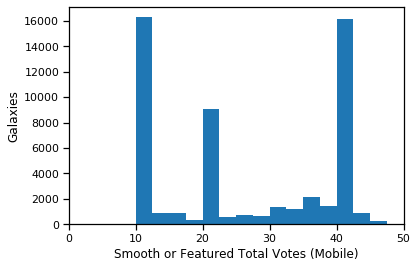

In [34]:
plt.hist(agg['smooth-or-featured_total-votes'], range=(0, 50), bins=20)
plt.xlabel('Smooth or Featured Total Votes (Mobile)')
plt.ylabel('Galaxies')
plt.xlim([0., 50.])

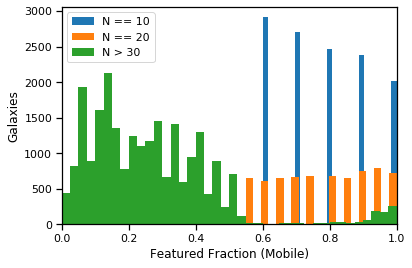

In [49]:
fig, ax = plt.subplots()

ax.set_xlabel('Featured Fraction (Mobile)')
ax.set_ylabel('Galaxies')
ax.set_xlim([0., 1.])

ax.hist(agg[agg['smooth-or-featured_total-votes'] == 10]['smooth-or-featured_featured-or-disk_fraction'], bins=25, label='N == 10')
ax.hist(smooth_agg[smooth_agg['smooth-or-featured_total-votes'] == 20]['smooth-or-featured_featured-or-disk_fraction'], bins=40, label='N == 20')
ax.hist(agg[agg['smooth-or-featured_total-votes'] > 30]['smooth-or-featured_featured-or-disk_fraction'], bins=40, label='N > 30')

plt.legend()

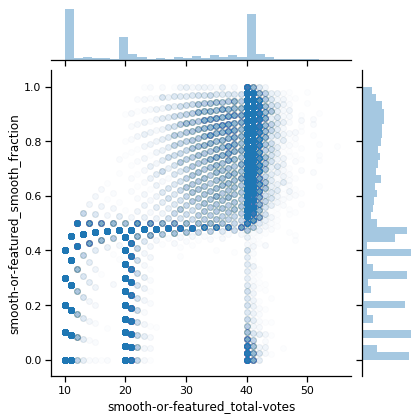

In [45]:
sns.jointplot(agg['smooth-or-featured_total-votes'], agg['smooth-or-featured_smooth_fraction'], alpha=.01)

In [51]:
# retirement until 24th nov 2020 was set to 40.
# So featured > smooth and classifications > 10 retired, so only smooth things could get 40 classifications.
# Oops. Retirement now correctly set to 10!

In [59]:
agg

,iauname,smooth-or-featured_smooth_fraction,smooth-or-featured_featured-or-disk_fraction,smooth-or-featured_total-votes,has-spiral-arms_yes_fraction,has-spiral-arms_no_fraction,has-spiral-arms_total-votes,merging_yes_fraction,merging_no_fraction,merging_total-votes
0,J000007.82-000226.0,0.125000,0.875000,40,0.933333,0.066667,15.0,0.170213,0.829787,47
1,J000012.78+010712.7,0.048780,0.951220,41,1.000000,0.000000,15.0,0.450980,0.549020,51
2,J000150.59+010157.1,0.625000,0.375000,40,0.066667,0.933333,15.0,0.755102,0.244898,49
3,J000321.63+010334.2,0.975000,0.025000,40,0.000000,1.000000,15.0,0.080000,0.920000,50
4,J000358.99+000710.7,0.609756,0.390244,41,NaN,NaN,NaN,0.333333,0.666667,12
...,...,...,...,...,...,...,...,...,...,...
53160,J235942.21+011017.0,0.853659,0.146341,41,NaN,NaN,NaN,0.000000,1.000000,10
53161,J235943.64+004241.5,0.900000,0.100000,40,NaN,NaN,NaN,0.142857,0.857143,14
53162,J235944.62+032243.7,0.900000,0.100000,40,NaN,NaN,NaN,0.166667,0.833333,12
53163,J235944.90+004643.0,0.400000,0.600000,10,0.000000,1.000000,37.0,0.300000,0.700000,10


(0.0, 50.0)

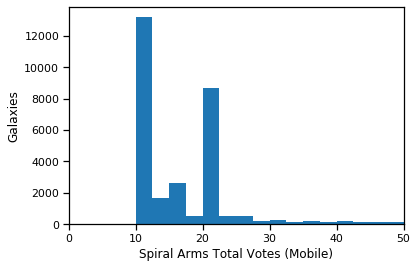

In [61]:
plt.hist(agg['has-spiral-arms_total-votes'], range=(0, 50), bins=20)
plt.xlabel('Spiral Arms Total Votes (Mobile)')
plt.ylabel('Galaxies')
plt.xlim([0., 50.])

(0.0, 50.0)

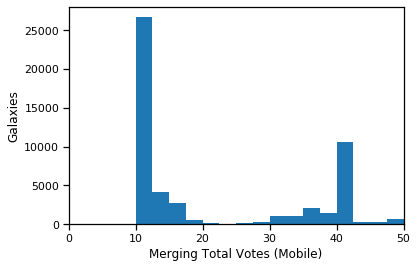

In [62]:
plt.hist(agg['merging_total-votes'], range=(0, 50), bins=20)
plt.xlabel('Merging Total Votes (Mobile)')
plt.ylabel('Galaxies')
plt.xlim([0., 50.])

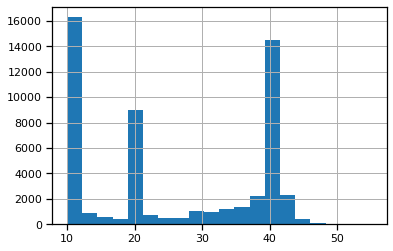

In [52]:
agg['smooth-or-featured_total-votes'].hist(bins=20)

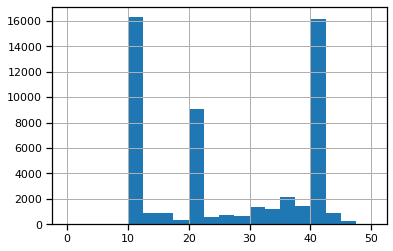

In [53]:
agg['smooth-or-featured_total-votes'].hist(bins=20, range=(0, 50))

In [54]:
dr5 = pd.read_parquet('/home/walml/repos/zoobot/current_final_dr5_result.parquet')

In [55]:
both = pd.merge(agg, dr5, on='iauname', how='inner', suffixes=('_mobile', '_dr5'))

In [56]:
len(agg), len(dr5), len(both)

(53012, 253225, 37264)

In [ ]:
both['smooth-or-featured_featured-or-disk_fraction_mobile'].hist(bins=20)

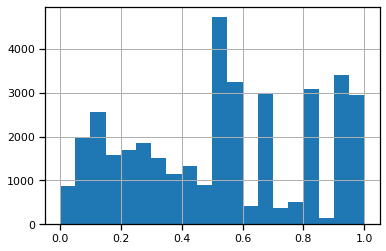

In [57]:
both['smooth-or-featured_featured-or-disk_fraction_mobile'].hist(bins=20)

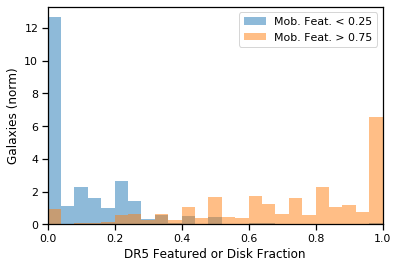

In [71]:
bins = 25
plt.hist(both[both['smooth-or-featured_featured-or-disk_fraction_mobile'] < 0.25]['smooth-or-featured_featured-or-disk_fraction_dr5'], density=True, alpha=.5, label='Mob. Feat. < 0.25', bins=bins)
plt.hist(both[both['smooth-or-featured_featured-or-disk_fraction_mobile'] > 0.75]['smooth-or-featured_featured-or-disk_fraction_dr5'], density=True, alpha=.5, label='Mob. Feat. > 0.75', bins=bins)
plt.xlabel('DR5 Featured or Disk Fraction')
plt.xlim([0., 1.])
plt.ylabel('Galaxies (norm)')
plt.legend()

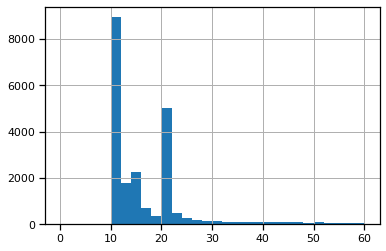

In [64]:
both['has-spiral-arms_total-votes_mobile'].hist(range=(0, 60), bins=30)
# was set to retire at 20, now set to retire at 10

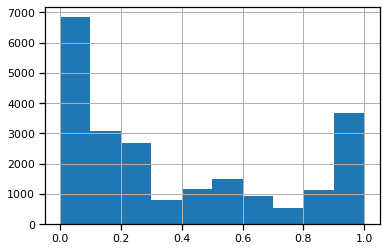

In [65]:
both['has-spiral-arms_yes_fraction_mobile'].hist()

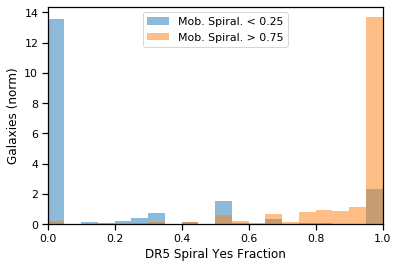

In [73]:
bins = 20
plt.hist(both[both['has-spiral-arms_yes_fraction_mobile'] < 0.25]['has-spiral-arms_yes_fraction_dr5'], density=True, alpha=.5, label='Mob. Spiral. < 0.25', bins=bins)
plt.hist(both[both['has-spiral-arms_yes_fraction_mobile'] > 0.75]['has-spiral-arms_yes_fraction_dr5'], density=True, alpha=.5, label='Mob. Spiral. > 0.75', bins=bins)
plt.xlabel('DR5 Spiral Yes Fraction')
plt.xlim([0., 1.])
plt.ylabel('Galaxies (norm)')
plt.legend()

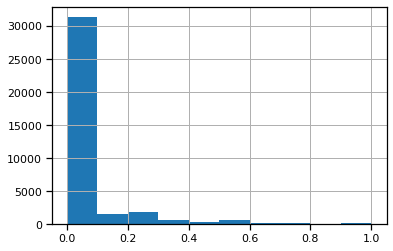

In [67]:
both['merging_merger_fraction'].hist()  # no mobile as no direct equiv. in dr5

Very promising for ML prioritisation, perhaps

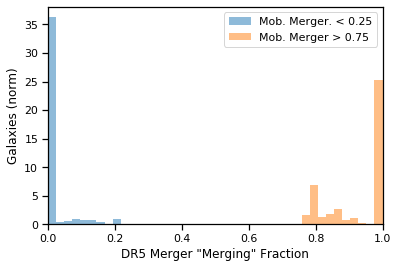

In [68]:
bins = 
plt.hist(both[both['merging_merger_fraction'] < 0.25]['merging_merger_fraction'], density=True, alpha=.5, label='Mob. Merger. < 0.25')
plt.hist(both[both['merging_merger_fraction'] > 0.75]['merging_merger_fraction'], density=True, alpha=.5, label='Mob. Merger > 0.75')
plt.xlabel('DR5 Merger "Merging" Fraction')
plt.xlim([0., 1.])
plt.ylabel('Galaxies (norm)')
plt.legend()